The following is a recursive algorithm for testing whether a graph $G$ is planar:
*   Find the core $G^*$ of G.
*   If $G^*$ is empty, then $G$ is planar.
*   Else find a cycle $C$ in $G^*$ with a chord $e$.
*   Find the bridges of $C$ in $G^*$ and the interleave graph $H$.
*   If $H$ is not bipartite then $G$ is not planar.
*   Else $G$ is planar if and only if $G^* - e$ is planar.

Here is a brief justification:
*   The two reduction operations (removing degree-one vertices and suppressing degree-two vertices) do not affect planarity. A graph $G$ can be drawn without edge crossings if and only if its core $G^*$ can. The first step effectively simplifies the problem to the essential highly-connected components.

*   In the base case where the core is empty, the original graph $G$ was composed entirely of paths and trees (i.e., it was a forest). A forest has no cycles and can always be drawn on a plane without any edge crossings.

*   Any non-empty core (where the minimum degree is at least $3$) is guaranteed to contain a cycle with a chord. In any planar drawing, the cycle $C$ divides the plane into an inside and an outside which divides the set of bridges.

    *   If the interleave graph $H$ is not bipartite, then it means that there is an odd cycle of interleaving bridges. It is impossible to assign these bridges to the inside and outside regions without at least one pair crossing.

    *   If the interleave graph $H$ is bipartite, then we can partition all the bridges into an inside set and an outside set such that no two bridges in the same set interleave. The chord $e$ is itself a bridge of $C$. Assume we place it in the inside set. All other inside bridges can be drawn in the appropriate sub-regions created by $e$ without conflict.
    
    *   The overall planarity of $G^*$ now hinges entirely on the planarity of the rest of the graph. Removing $e$ does not change planarity, so we can now recursively apply the algorithm to eventually reach an answer.

*   The algorithm is guaranteed to terminate because in each recursive step, we remove one edge $e$ from the finite graph $G^*$. The recursion must eventually either find a non-bipartite interleave graph or reduce the graph until its core becomes empty.

In [376]:
# @title Helper functions from before
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations
import numpy as np
import io

def find_core(graph):
    g_core = graph.copy()
    q = deque([node for node in g_core.nodes() if g_core.degree(node) in [1, 2]])
    while q:
        v = q.popleft()
        if v not in g_core or g_core.degree(v) not in [1, 2]: continue
        if g_core.degree(v) == 1:
            neighbor = list(g_core.neighbors(v))[0]
            g_core.remove_node(v)
            if neighbor in g_core and g_core.degree(neighbor) in [1, 2]: q.append(neighbor)
        elif g_core.degree(v) == 2:
            u, w = list(g_core.neighbors(v))
            g_core.remove_node(v)
            if u != w and not g_core.has_edge(u, w): g_core.add_edge(u, w)
            if u in g_core and g_core.degree(u) in [1, 2]: q.append(u)
            if w in g_core and g_core.degree(w) in [1, 2]: q.append(w)

    # Extra feature to remove isolated vertices.
    g_core.remove_nodes_from([node for node in g_core.nodes() if g_core.degree(node) == 0])
    return g_core

def find_cycle(graph):
    if len(graph) == 0:
        return None
    start = next(iter(graph.nodes()))
    visited = {start}
    path = [start]
    current = start
    while True:
        unvisited_neighbours = [n for n in graph.neighbors(current) if n not in visited]
        if unvisited_neighbours:
            next_vertex = unvisited_neighbours[0]
            visited.add(next_vertex)
            path.append(next_vertex)
            current = next_vertex
        else:
            for neighbour in graph.neighbors(current):
                if neighbour in path:
                    cycle_start_idx = path.index(neighbour)
                    cycle = path[cycle_start_idx:] + [neighbour]
                    return cycle
            return None

def has_chord(graph, cycle):
    cycle_set = set(cycle[:-1])
    cycle_list = cycle[:-1]
    n = len(cycle_list)
    for i, v in enumerate(cycle_list):
        for neighbour in graph.neighbors(v):
            if neighbour in cycle_set:
                neighbour_idx = cycle_list.index(neighbour)
                distance = min(abs(i - neighbour_idx), n - abs(i - neighbour_idx))
                if distance > 1:
                    return True, (v, neighbour)
    return False, None

def find_cycle_with_chord(graph):
    if min(dict(graph.degree()).values()) < 3:
        raise ValueError("Graph must have minimum degree of at least 3")
    for start in graph.nodes():
        queue = deque()
        queue.append((start, [start]))
        visited_states = set()
        visited_states.add((start, tuple([start])))
        while queue:
            current, path = queue.popleft()

            if len(path) > len(graph):
                continue
            for neighbor in graph.neighbors(current):
                if neighbor == start and len(path) >= 4:
                    cycle = path
                    cycle_edges = set()
                    for i in range(len(cycle)):
                        u = cycle[i]
                        v = cycle[(i + 1) % len(cycle)]
                        cycle_edges.add(tuple(sorted([u, v])))
                    cycle_set = set(cycle)
                    for u in cycle:
                        for v in graph.neighbors(u):
                            if v in cycle_set:
                                edge = tuple(sorted([u, v]))
                                if edge not in cycle_edges:
                                    return (cycle, (u, v))
                elif neighbor not in path:
                    new_path = path + [neighbor]
                    state = (neighbor, tuple(new_path))
                    if state not in visited_states:
                        visited_states.add(state)
                        queue.append((neighbor, new_path))
    return None


def find_graph_components(graph):
    components, visited = [], set()
    for node in graph.nodes():
        if node not in visited:
            comp, q = [], deque([node]); visited.add(node)
            while q:
                u = q.popleft(); comp.append(u)
                for v in graph.neighbors(u):
                    if v not in visited: visited.add(v); q.append(v)
            components.append(comp)
    return components

def find_bridges_of_cycle(graph, cycle_nodes):
    bridges = []
    cycle_nodes_set = set(cycle_nodes)
    cycle_edges = {tuple(sorted((cycle_nodes[i], cycle_nodes[(i + 1) % len(cycle_nodes)]))) for i in range(len(cycle_nodes))}
    for u, v in graph.edges():
        if u in cycle_nodes_set and v in cycle_nodes_set and tuple(sorted((u, v))) not in cycle_edges:
            bridges.append({'edges': [(u, v)], 'attachments': sorted([u, v])})
    subgraph = graph.subgraph([n for n in graph.nodes() if n not in cycle_nodes_set])
    for component_nodes in find_graph_components(subgraph):
        comp_edges = set(subgraph.subgraph(component_nodes).edges())
        attachments = set()
        for node in component_nodes:
            for neighbor in graph.neighbors(node):
                if neighbor in cycle_nodes_set: comp_edges.add(tuple(sorted((node, neighbor)))); attachments.add(neighbor)
        if comp_edges: bridges.append({'edges': list(comp_edges), 'attachments': sorted(list(attachments))})
    return bridges

def construct_interleave_graph(cycle_nodes, bridges):
    H = nx.Graph(); H.add_nodes_from(range(len(bridges)))
    node_to_pos = {node: i for i, node in enumerate(cycle_nodes)}
    for i, j in combinations(range(len(bridges)), 2):
        atts1, atts2 = set(bridges[i]['attachments']), set(bridges[j]['attachments'])
        if len(atts1) == 3 and atts1 == atts2: H.add_edge(i, j); continue
        pos1, pos2 = sorted([node_to_pos[n] for n in atts1]), sorted([node_to_pos[n] for n in atts2])
        interleaves = False
        for p1a, p1c in combinations(pos1, 2):
            for p2b, p2d in combinations(pos2, 2):
                if (p1a < p2b < p1c < p2d) or (p2b < p1a < p2d < p1c): interleaves = True; break
            if interleaves: break
        if interleaves: H.add_edge(i, j)
    return H

def is_bipartite(graph):
    colors = {}
    for start_node in graph.nodes():
        if start_node not in colors:
            colors[start_node] = 1; q = deque([start_node])
            while q:
                u = q.popleft()
                for v in graph.neighbors(u):
                    if v not in colors: colors[v] = -1 * colors[u]; q.append(v)
                    elif colors[v] == colors[u]: return False
    return True

def draw_graph(graph_object, outer_cycle_nodes, title):
    pos = {}
    k = len(outer_cycle_nodes)
    for i, node in enumerate(outer_cycle_nodes):
        angle = 2 * np.pi * i / k
        pos[node] = (np.cos(angle), np.sin(angle))
    internal_nodes = [node for node in graph_object.nodes() if node not in outer_cycle_nodes]
    if internal_nodes:
        n_internal = len(internal_nodes)
        node_to_idx = {node: i for i, node in enumerate(internal_nodes)}
        A = np.zeros((n_internal, n_internal))
        b_x = np.zeros(n_internal)
        b_y = np.zeros(n_internal)

        for i, node in enumerate(internal_nodes):
            A[i, i] = graph_object.degree(node)
            for neighbor in graph_object.neighbors(node):
                if neighbor in internal_nodes:
                    j = node_to_idx[neighbor]
                    A[i, j] = -1.0
                else:
                    b_x[i] += pos[neighbor][0]
                    b_y[i] += pos[neighbor][1]
        try:
            internal_x = np.linalg.lstsq(A, b_x, rcond=None)[0]
            internal_y = np.linalg.lstsq(A, b_y, rcond=None)[0]
            for i, node in enumerate(internal_nodes):
                pos[node] = (internal_x[i], internal_y[i])
        except np.linalg.LinAlgError:
            print(f"Could not solve for positions in {title}. The matrix may be singular.")
            for node in internal_nodes:
                if node not in pos: pos[node] = (0, 0)
    plt.figure(figsize=(5, 5))
    nx.draw(graph_object, pos, with_labels=True)
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [377]:
def is_planar(graph):
    '''
    Determines if a graph is planar using the recursive algorithm.
    Args:
        graph: The graph to test.
    Returns:
        True if the graph is planar, False otherwise.
    '''
    # Find the core of the graph
    g_core = find_core(graph)

    # Base case: If the core is empty, then the graph is planar.
    if g_core.number_of_edges() == 0:
        return True

    # Find a cycle C with a chord e in the core.
    cycle_chord_pair = find_cycle_with_chord(g_core)
    if not cycle_chord_pair:
        # This case should not be reached for non-empty cores.
        print(f"  Minimal degree of core is {min(dict(g_core.degree()).values())}")
        print(g_core.edges())
        raise ValueError("  Cycle or chord is None")

    cycle, chord = cycle_chord_pair

    # Find bridges of C and the interleave graph H.
    bridges = find_bridges_of_cycle(g_core, cycle)
    interleave_graph = construct_interleave_graph(cycle, bridges)

    # If H is not bipartite, the graph is not planar.
    if not is_bipartite(interleave_graph):
        return False

    # Recursive step: The graph is planar if and only if the core minus the chord is planar.
    g_core_minus_chord = g_core.copy()
    g_core_minus_chord.remove_edge(*chord)

    return is_planar(g_core_minus_chord)

In [378]:
# K5: The complete graph on 5 vertices
G_k5 = nx.complete_graph(5)
print(f"Is K_5 planar?")
print(f"  {is_planar(G_k5)}")

# K3,3: The utility graph
G_k3_3 = nx.complete_bipartite_graph(3, 3)
print(f"Is K_3,3 planar?")
print(f"  {is_planar(G_k3_3)}")

# A tree (should have an empty core)
G_tree = nx.balanced_tree(2, 3)
print(f"Is a tree planar?")
print(f"  {is_planar(G_tree)}")

# An empty graph
G_empty = nx.Graph()
print(f"Is an empty graph planar?")
print(f"  {is_planar(G_empty)}")

Is K_5 planar?
  False
Is K_3,3 planar?
  False
Is a tree planar?
  True
Is an empty graph planar?
  True


In [379]:
# @title Edge Lists for Platonic Solids
platonic_data = {
    'Tetrahedron': {'outer_cycle': [1, 2, 3], 'edgelist_string': """
        1 2
        1 3
        1 4
        2 3
        2 4
        3 4
    """ }, 'Cube': {'outer_cycle': [1, 2, 3, 4], 'edgelist_string': """
        1 2
        1 4
        1 8
        2 3
        2 7
        3 4
        3 6
        4 5
        5 6
        5 8
        6 7
        7 8
    """ }, 'Octahedron': {'outer_cycle': [1, 2, 3], 'edgelist_string': """
        1 2
        1 3
        1 4
        1 5
        2 3
        3 4
        4 5
        5 2
        6 2
        6 3
        6 4
        6 5
    """ }, 'Dodecahedron': {'outer_cycle': [1, 2, 3, 4, 5], 'edgelist_string': """
        1  2
        2  3
        3  4
        4  5
        5  1
        1 12
        2 14
        3  6
        4  8
        5 10
        6  7
        7  8
        8  9
        9 10
        10 11
        11 12
        12 13
        13 14
        14 15
        15  6
        15 16
        7 17
        9 18
        11 19
        13 20
        16 17
        17 18
        18 19
        19 20
        20 16
    """ }, 'Icosahedron': {'outer_cycle': [1, 2, 3], 'edgelist_string': """
        1  2
        1  3
        1  4
        1  5
        1  6
        2  3
        3  4
        4  5
        5  6
        6  2
        2 11
        2  7
        3  7
        3  8
        4  8
        4  9
        5  9
        5 10
        6 10
        6 11
        7  8
        8  9
        9 10
        10 11
        11 7
        7 12
        8 12
        9 12
        10 12
        11 12
    """ }
}

In [380]:
for name, data in platonic_data.items():
    edgelist_str = data['edgelist_string']
    s_file = io.StringIO(edgelist_str)
    G = nx.read_edgelist(s_file, nodetype=int)
    print(f"Testing {name} for planarity:")
    print(f"  {is_planar(G)}")

Testing Tetrahedron for planarity:
  True
Testing Cube for planarity:
  True
Testing Octahedron for planarity:
  True
Testing Dodecahedron for planarity:
  True
Testing Icosahedron for planarity:
  True


Consider building a random maximal planar graph with $n$ vertices, by starting with the empty graph, and testing each of the $\binom{n}{2}$ possible edges in a random order: if the addition of an edge maintains planarity, keep it
in the graph, but if it violates planarity, discard it. Euler's formula states for planar graphs that
\begin{equation}
    V - E + F = 2,
\end{equation}
where $V$, $E$, $F$ are the number of vertices, edges and faces respectively. In a maximal planar graph, every face is a triangle, and each edge is adjacent to exactly two faces. If we sum the number of edges for each face, we get $3f$. Since this counts every edge twice, we have the relationship
\begin{equation}
    2E = 3F \implies F = \frac{2E}{3},
\end{equation}
and substituting this into Euler's formula yields
\begin{equation}
    E = 3V - 6.
\end{equation}
Therefore, a maximal planar graph with $n$ vertices will always have exactly $3n - 6$ edges.

To estimate the complexity of the recursive planarity testing algorithm, we need to analyse two main factors:
*   The amount of work done within a single call to the function.
*   The total number of recursive calls made.
The final complexity will be the product of these two factors. Let $V$ be the number of vertices and $E$ be the number of edges in the graph at a given step.

A single call involves executing a sequence of functions. The total work for one call is determined by the most expensive function in this sequence.
*   Finding the core uses a queue to iteratively remove vertices of degree $1$ and $2$. Each vertex and edge is processed a constant number of times. This is a linear-time operation.
    *   Complexity: $O(V + E)$
*   Finding a cycle with a chord is based on graph traversal (DFS and BFS). It visits each vertex and edge a constant number of times to find an initial cycle and then potentially a bridge path.
    *   Complexity: $O(V + E)$
*   Finding the bridges of a cycle involves iterating through the graph's edges and components. This is fundamentally a graph traversal.
    *   Complexity: $O(V + E)$
*   The interleave graph $H$ has one node per bridge of $C$, and edges correspond to interleaving intervals on $C$. Building $H$ requires examining each attachment point on $C$. Sorting and interval comparisons take at most $O(L\log{L})$, where $L \leq E$ is the number of bridges.
    *   Complexity: $O(E\log E)$
*   Checking whether a graph is bipartite is a standard BFS/DFS coloring algorithm. Its complexity is linear in the size of the interleave graph $H$ and scales as the sum of the number of vertices and number of edges in $H$.
    *   Complexity: $O(V + E)$
    
Therefore, the complexity of one call is roughly $O(V + E\log(E))$.

In each recursive step, exactly one edge (the chord $e$) is removed from the core graph. The recursion stops when the core becomes empty or when the interleave graph is found to be non-bipartite. The number of edges $E$ in a simple planar graph is at most $3V - 6$. Therefore, $E$ is O(V). Since one edge is removed at each step, the maximum depth of the recursion is the total number of edges in the initial core, which is $O(V)$.

Total complexity is therefore
\begin{equation}
    O(EV + E^2\log{E}).
\end{equation}
Using sparsity of the candidate graphs for planarity, $E = O(V)$, this simplifies to $O(V^2\log(V))$.

Theoretical maximum number of edges: 3 * 45 - 6 = 129
Id   Edges
---------
1    46
2    48
3    36
4    43
5    59
6    43
7    41
8    43
9    39
10   44
11   38
12   48
13   47
14   53
15   43
16   45
17   37
18   46
19   49
20   45
21   56
22   59
23   42
24   47
25   52
26   52
27   46
28   47
29   33
30   48


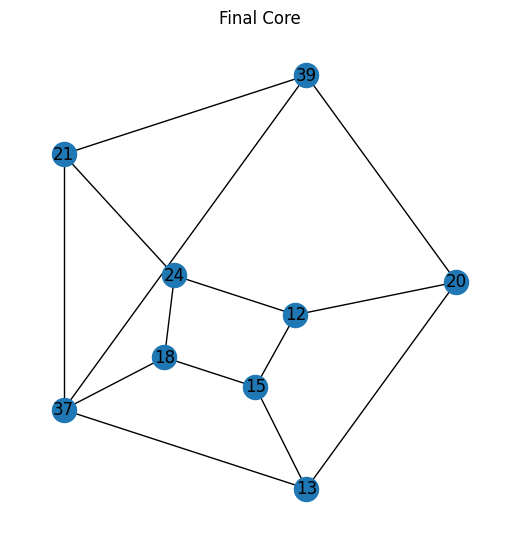

Cycle: [20, 39, 21, 37, 13]


In [381]:
import random
def test_random_graph(n):
    '''
    Tests a random graph for planarity by successively adding edges in random order.
    Args:
        n: The number of vertices in the graph
    Returns:
        The final graph before the first violation.
        Number of edges before the first violation.
    '''
    # Start with an empty graph
    G = nx.Graph()

    # Test each of the (n choose 2) vertices in random order
    edges = list(combinations(range(1, n + 1), 2))
    random.shuffle(edges)

    first_violation = 0
    for (u, v) in edges:
        # Add the edge
        G.add_edge(u, v)

        # If G is not planar, then discard the edge
        if not is_planar(G):
            G.remove_edge(u, v)
            if not first_violation:
                # Number of edges at first violation
                first_violation = len(G.edges())
                return G,  first_violation

n = 45
theoretical_max = 3 * n - 6
print(f"Theoretical maximum number of edges: 3 * {n} - 6 = {theoretical_max}")
# Make a table
print(f"{'Id':<4} Edges")
print("---------")
for i in range(30):
    graph, first_violation = test_random_graph(n)
    print(f"{i+1:<4} {first_violation}")

# Find the core of the graph to ensure vertices have degree at least 3
graph_core = find_core(graph)
# Find a cycle with one bridge for outer vertices
cycle_chord_pair = find_cycle_with_chord(graph_core)
cycle, chord = cycle_chord_pair
# Plot the core graph for clarity
draw_graph(graph_core, cycle, "Final Core")
print(f"Cycle: {cycle}")
